# Проект "Исследовательский анализ данных"

# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0      108.00  2019-03-07T00:00:00      3   
1             7   3350000.0       40.40  2018-12-04T00:00:00      1   
2            10   5196000.0       56.00  2015-08-20T00:00:00      2   
3             0  64900000.0      159.00  2015-07-24T00:00:00      3   
4             2  10000000.0      100.00  2018-06-19T00:00:00      2   
5            10   2890000.0       30.40  2018-09-10T00:00:00      1   
6             6   3700000.0       37.30  2017-11-02T00:00:00      1   
7             5   7915000.0       71.60  2019-04-18T00:00:00      2   
8            20   2900000.0       33.16  2018-05-23T00:00:00      1   
9            18   5400000.0       61.00  2017-02-26T00:00:00      3   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0        51.00      8          NaN  ...   
1             NaN          11.0        18.60      1          NaN  ...   

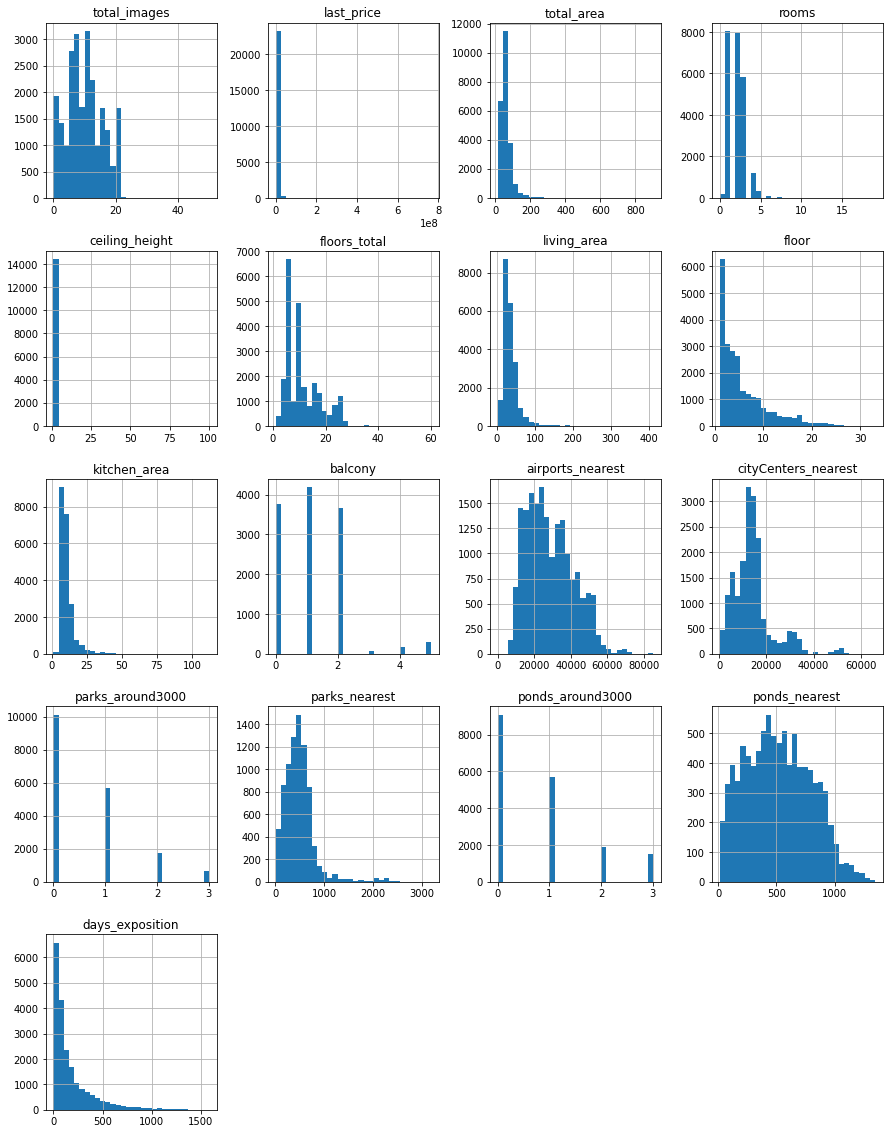

In [1]:
# загрузим и изучим данные
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print(df.head(10))
df.info()
df.hist(figsize=(15, 20), bins=30)
plt.show()



### Предобработка данных

In [2]:
# находим количество пропусков в каждом столбце

pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


In [3]:
# в столбце с количеством балконов заполняем пропуски нулями, т.к. в соответствующих квартирах их, скорее всего, нет
df['balcony'] = df['balcony'].fillna(0)

# меняем пропуски в названиях населенных пунктов на "Не определено"
df['locality_name'] = df['locality_name'].fillna('Не определено')

# в столбце с количеством парков заполняем пропуски нулями, т.к. в рядом с соответствующими квартирами их, скорее всего, нет
df['parks_around3000'] = df['parks_around3000'].fillna(0)

# в столбце с количеством озёр заполняем пропуски нулями, т.к. в рядом с соответствующими квартирами их, скорее всего, нет
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)

# заполняем пропуски в количестве этажей медианным значением. Это не сильно повлияет на выводы, т.к. пропусков не много
df['floors_total'] = df['floors_total'].fillna(df['floors_total'].median())

# заполняем пропуски в количестве дней показа медианнымзначением. Это не сильно повлияет на выводы, т.к. пропусков не много
df['days_exposition'] = df['days_exposition'].fillna(df['days_exposition'].median())

Пропуски в таких столбцах как 'balcony' и 'is_apartment' могли возникнуть из за того, что в квартире не было балконов, она не была апартаментами и продавец не стал заполнять соответствующие ячейки.

В таких столбцах как 'kitchen_area' и 'ceiling_height' продавец мог не внести значения, чтобы не отпугнуть вероятных покупателей низким потолком или маленькой кухней.

Большую часть таких пропусков можно отнести к неслучайным.

При этом пропуски в таких столбцах как 'days_exposition', 'parks_nearest' и 'ponds_nearest' не заполняются продавцом и, скорее всего, носят случайный характер.

In [4]:
# в столбце 'ceiling_height' заполним пропуски медианным значением для каждого населенного пункта
for locality_name in df['locality_name'].unique():
    median = df.loc[df['locality_name'] == locality_name, 'ceiling_height'].median()
    df.loc[(df['ceiling_height'].isna()) & (df['locality_name'] == locality_name), 'ceiling_height'] = median
    
# оставшиеся пропуски заполняем медианой по области
df.loc[df['ceiling_height'].isna(), 'ceiling_height'] = df['ceiling_height'].median

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/p

In [5]:
# в столбце 'cityCenters_nearest' так же заполним пропуски медианным значением для каждого населенного пункта
for locality_name in df['locality_name'].unique():
    median = df.loc[df['locality_name'] == locality_name, 'cityCenters_nearest'].median()
    df.loc[(df['cityCenters_nearest'].isna()) & (df['locality_name'] == locality_name), 'cityCenters_nearest'] = median

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/p

In [6]:
# меняем цену на тип int для удобства чтения
df['last_price'] = pd.to_numeric(df['last_price'], errors='ignore').astype('int')

# меняем общую площадь на тип int для удобства чтения
df['total_area'] = pd.to_numeric(df['total_area'], errors='ignore').astype('int')

# меняем формат даты на формат даты без времени, т.к. время не указано
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format = '%Y.%m.%d')

# меняем количество этажей на тип int для удобства чтения
df['floors_total'] = pd.to_numeric(df['floors_total'], errors='ignore').astype('int')

# меняем количество балконов на тип int для удобства чтения
df['balcony'] = pd.to_numeric(df['balcony'], errors='ignore').astype('int')

# меняем количество парков на тип int для удобства чтения
df['parks_around3000'] = pd.to_numeric(df['parks_around3000'], errors='ignore').astype('int')

# меняем количество озёр на тип int для удобства чтения
df['ponds_around3000'] = pd.to_numeric(df['ponds_around3000'], errors='ignore').astype('int')

# меняем дни показа объявления на тип int для удобства чтения
df['days_exposition'] = pd.to_numeric(df['days_exposition'], errors='ignore').astype('int')

В столбце 'first_day_exposition' указана только дата без времени, поэтому имеет смысл изменить формат столбца, убрав из него время.

В столбцах 'last_price', 'total_area', 'floors_total' и прочих следует изменить фотмат на целочисленный для удобства чтения и обработки данных.

In [7]:
# проверяем результат
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int64         
 2   total_area            23699 non-null  int64         
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  object        
 6   floors_total          23699 non-null  int64         
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

In [8]:
# найдём количество явных дубликатов
df.duplicated().sum()

0

Явные дубликаты отсутствуют

In [9]:
# найдём все уникальные названия населенных пунктов
print(df['locality_name'].unique())

# и их количество.
print()
print(df['locality_name'].nunique())

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

In [10]:
# устраним неявные дубликаты
df['locality_name'] = df['locality_name'].apply(lambda x: x.replace('поселок городского типа', 'поселок'))
df['locality_name'] = df['locality_name'].apply(lambda x: x.replace('посёлок городского типа', 'поселок'))
df['locality_name'] = df['locality_name'].apply(lambda x: x.replace('городской поселок', 'поселок'))
df['locality_name'] = df['locality_name'].apply(lambda x: x.replace('городской посёлок', 'поселок'))
df['locality_name'] = df['locality_name'].apply(lambda x: x.replace('посёлок', 'поселок'))

In [11]:
# найдем количество уникальных названий населенных пунктов после удаления дубликатов
print(df['locality_name'].nunique())

323


Найдём и устраним аномальные значения

In [12]:
# в столбце с количеством комнат встречаются нулевые значения. Найдём их количество
print(len(df.query('rooms == 0')))


197


In [13]:
# удалим эти строки
df = df.loc[(df['rooms'] != 0)]

In [14]:
# проверим результат
print(len(df.query('rooms == 0')))

0


In [15]:
# в столбце с высотой потолков встречаются аномально большие значения. Выведем их на экран

df['good_ceiling_height'] = pd.to_numeric(df['ceiling_height'], errors='coerce')
df.query('good_ceiling_height > 7')


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,good_ceiling_height
313,1,2450000,49,2016-03-09,3,13.85,5,34.0,2,NaN,...,1,поселок Новый Свет,NaN,NaN,0,NaN,0,NaN,189,13.85
355,17,3600000,55,2018-07-12,2,25.0,5,32.0,2,False,...,2,Гатчина,NaN,NaN,0,NaN,0,NaN,259,25.00
2158,15,1500000,42,2017-12-23,2,27.0,2,29.0,2,NaN,...,0,деревня Мины,NaN,NaN,0,NaN,0,NaN,95,27.00
3148,14,2900000,75,2018-11-12,3,32.0,3,53.0,2,NaN,...,0,Волхов,NaN,NaN,0,NaN,0,NaN,95,32.00
3474,3,1400000,30,2018-03-16,1,8.0,5,15.3,2,False,...,0,деревня Нурма,NaN,NaN,0,NaN,0,NaN,125,8.00
4643,0,4300000,45,2018-02-01,2,25.0,9,30.0,2,NaN,...,1,Санкт-Петербург,12016.0,13256.0,1,658.0,1,331.0,181,25.00
5076,0,3850000,30,2018-10-03,1,24.0,5,19.5,1,True,...,0,Санкт-Петербург,29686.0,8389.0,3,397.0,1,578.0,7,24.00
5246,0,2500000,54,2017-10-13,2,27.0,5,30.0,3,NaN,...,2,деревня Мины,NaN,NaN,0,NaN,0,NaN,540,27.00
5669,4,4400000,50,2017-08-08,2,26.0,9,21.3,3,NaN,...,2,Санкт-Петербург,28981.0,10912.0,1,305.0,0,NaN,267,26.00
5807,17,8150000,80,2019-01-09,2,27.0,36,41.0,13,NaN,...,5,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,38,27.00


In [16]:
# присутствуют значения от 20 до 40, которые могли возникнуть из за неправильно поставленой точки. Разделим их на 10
df.loc[(20 < df['good_ceiling_height']) & (df['good_ceiling_height'] < 40), ['good_ceiling_height']] = df.loc[(20 < df['good_ceiling_height']) & (df['good_ceiling_height'] < 40), ['good_ceiling_height']] / 10

In [17]:
# удалим оставшиеся аномальные значения
df = df.loc[(df['good_ceiling_height'] < 7)]

In [18]:
# проверим, остались ли аномальные значения
df.query('good_ceiling_height > 7')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,good_ceiling_height


Логика возникновения части аномальных значений, таких как маловероятная высота потолков, была понятна. Эти значения удалось исправить. Те аномалии, чья логика не ясна и количество не велико, следует удалить.

### Посчитайте и добавьте в таблицу новые столбцы

In [19]:
# создаем столбец с ценой квадратного метра
df['square_meter_price'] = (df['last_price'] / df['total_area']).round(2)
print(df['square_meter_price'].head(5))

0    120370.37
1     83750.00
2     92785.71
3    408176.10
4    100000.00
Name: square_meter_price, dtype: float64


In [20]:
# создаем столбец с днём недели, когда обёявление было опубликовано
df['publication_week_day'] = df['first_day_exposition'].dt.weekday
print(df['publication_week_day'].head(5))

0    3
1    1
2    3
3    4
4    1
Name: publication_week_day, dtype: int64


In [21]:
# создаем столбец с месяцем, когда обёявление было опубликовано
df['publication_month'] = df['first_day_exposition'].dt.month
print(df['publication_month'].head(5))

0     3
1    12
2     8
3     7
4     6
Name: publication_month, dtype: int64


In [22]:
# создаем столбец с годом, когда обёявление было опубликовано
df['publication_year'] = df['first_day_exposition'].dt.year
#print(df['publication_year'].head(5))

In [23]:
# создаем столбец с типом этажа квартиры
def floor_type(row):
    floor = row['floor']
    floors_total = row['floors_total']
    
    if floor == 1:
        return 'Первый'
    if floor == floors_total:
        return 'Последний'
    else:
        return 'Другой'
     
row_columns = ['floor'], ['floors_total']
row = pd.Series(row_columns)

df['floor_type'] = df.apply(floor_type, axis=1)
#print(df['floor_type'].head(10))

In [24]:
# создаем столбец с расстоянием до центра в километрах
def cityCenters_km(row):
    cityCenters_nearest = row['cityCenters_nearest']
   
    return (pd.to_numeric(cityCenters_nearest, errors='ignore') / 1000)
     
row_columns = ['cityCenters_nearest']
row = pd.Series(row_columns)

df['cityCenters_km'] = df.apply(cityCenters_km, axis=1)
df['cityCenters_km'] = df['cityCenters_km'].round(0)
#print(df['cityCenters_km'].head(10))

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23372 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23372 non-null  int64         
 1   last_price            23372 non-null  int64         
 2   total_area            23372 non-null  int64         
 3   first_day_exposition  23372 non-null  datetime64[ns]
 4   rooms                 23372 non-null  int64         
 5   ceiling_height        23372 non-null  object        
 6   floors_total          23372 non-null  int64         
 7   living_area           21506 non-null  float64       
 8   floor                 23372 non-null  int64         
 9   is_apartment          2755 non-null   object        
 10  studio                23372 non-null  bool          
 11  open_plan             23372 non-null  bool          
 12  kitchen_area          21320 non-null  float64       
 13  balcony         

### Проведите исследовательский анализ данных

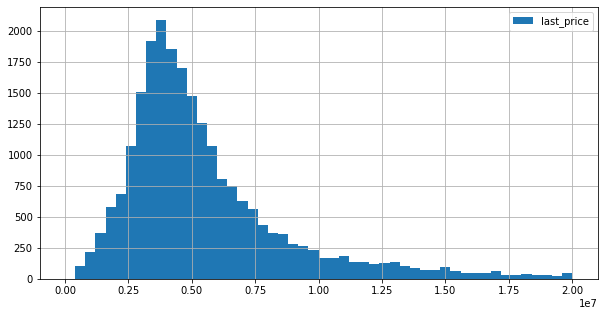

In [26]:
# построим гистограммы следующих столбцов

df['last_price'].hist(legend='last_price', figsize=(10, 5), range=(0, 20000000), bins=50)
plt.show()

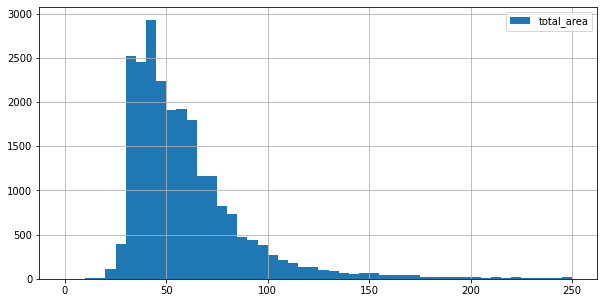

In [27]:
df['total_area'].hist(legend='total_area', figsize=(10, 5), range=(0, 250), bins=50)
plt.show()

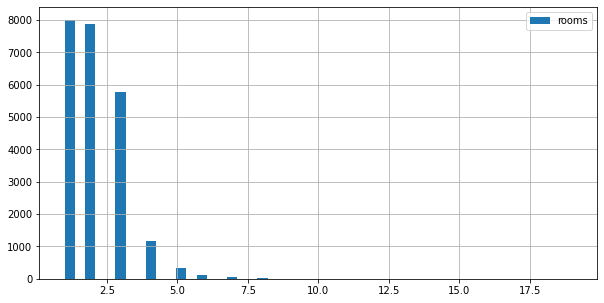

In [28]:
df['rooms'].hist(legend='rooms', figsize=(10, 5), bins=50)
plt.show()

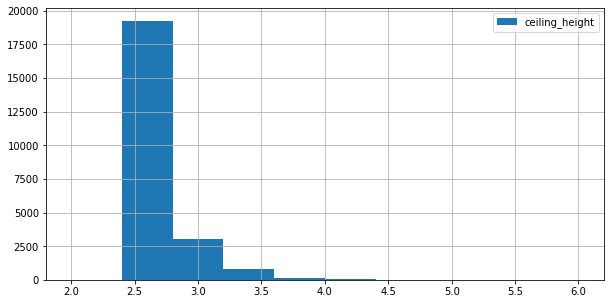

In [29]:
df['ceiling_height'].sort_values().hist(legend='ceiling_height', figsize=(10, 5), range=(2, 6), bins=10)
plt.show()

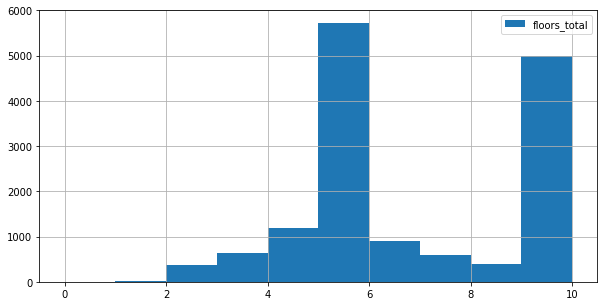

In [30]:
df['floors_total'].hist(legend='floors_total', figsize=(10, 5), range=(0,10), bins=10)
plt.show()

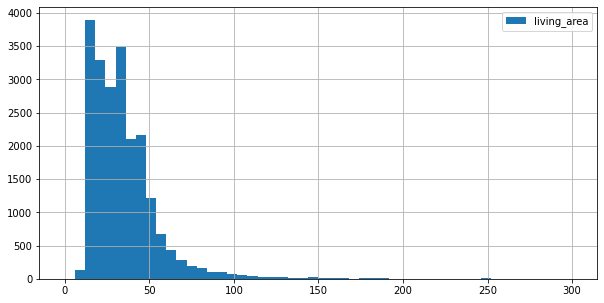

In [31]:
df['living_area'].hist(legend='living_area', figsize=(10, 5), range=(0, 300), bins=50)
plt.show()


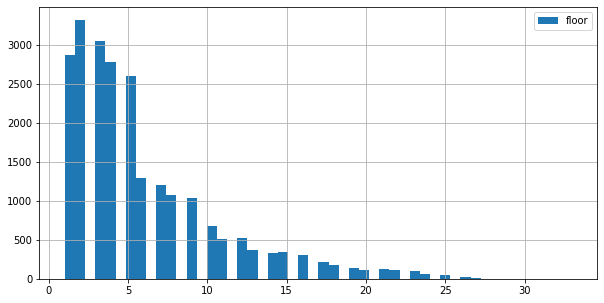

In [32]:
df['floor'].hist(legend='floor', figsize=(10, 5), bins=50)
plt.show()

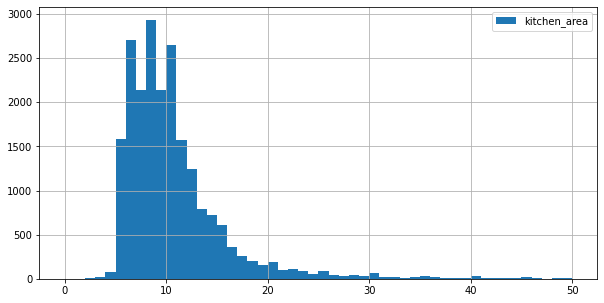

In [33]:
df['kitchen_area'].hist(legend='kitchen_area', figsize=(10, 5), range=(0, 50), bins=50)
plt.show()

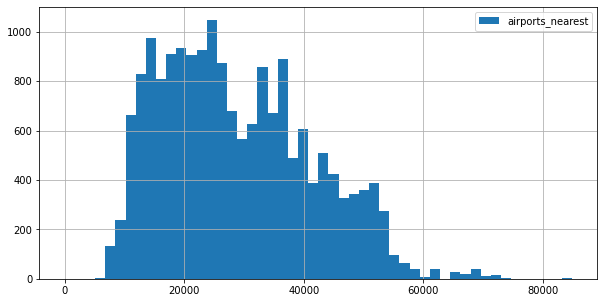

In [34]:
df['airports_nearest'].hist(legend='airports_nearest', figsize=(10, 5), bins=50)
plt.show()

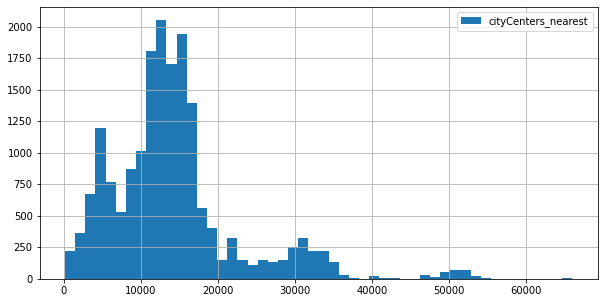

In [35]:
df['cityCenters_nearest'].hist(legend='cityCenters_nearest', figsize=(10, 5), bins=50)
plt.show()

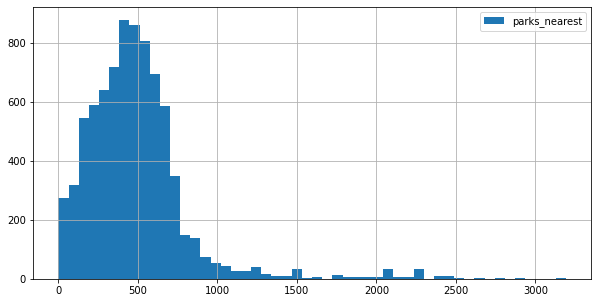

In [36]:
df['parks_nearest'].hist(legend='parks_nearest', figsize=(10, 5), bins=50)
plt.show()

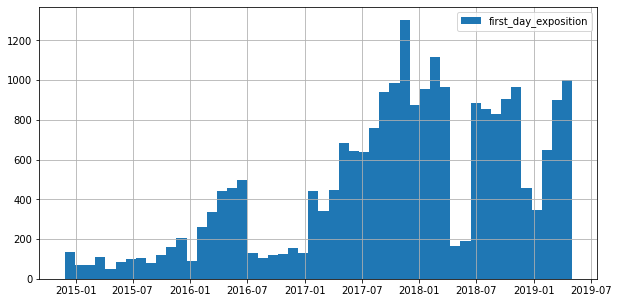

In [37]:
df['first_day_exposition'].hist(legend='first_day_exposition', figsize=(10, 5), bins=50)
plt.show()

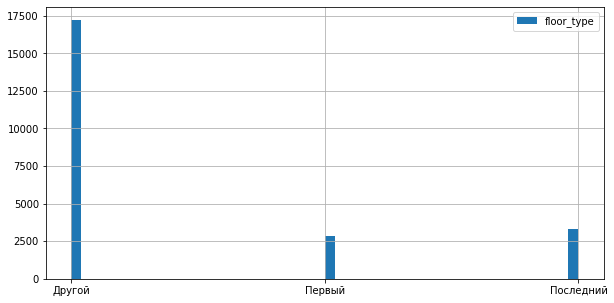

In [38]:
df['floor_type'].hist(legend='floor_type', figsize=(10, 5), bins=50)
plt.show()

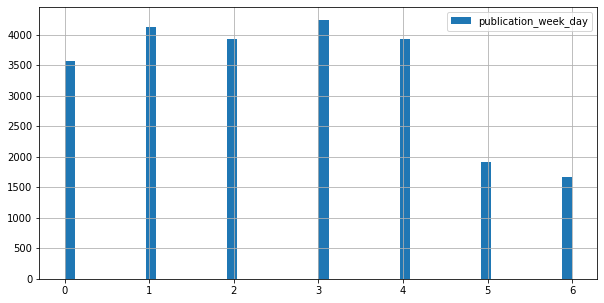

In [39]:
df['publication_week_day'].hist(legend='floor_type', figsize=(10, 5), bins=50)
plt.show()

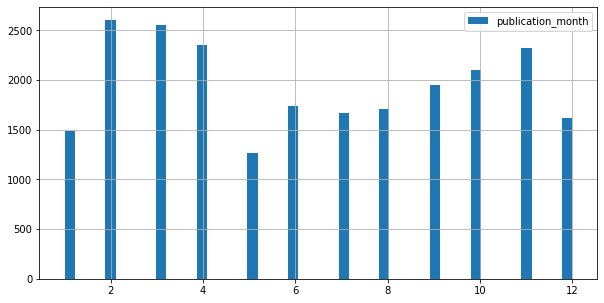

In [40]:
df['publication_month'].hist(legend='floor_type', figsize=(10, 5), bins=50)
plt.show()

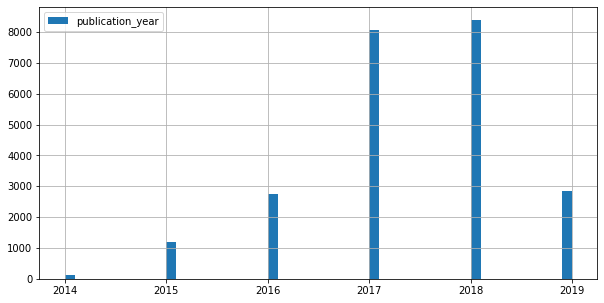

In [41]:
df['publication_year'].hist(legend='floor_type', figsize=(10, 5), bins=50)
plt.show()

Чаще всего встречаются объекты, имеющщие:

- цену от 3 000 000 до 6 000 000
- общую площадь от 30 до 80
- до 3-х комнат
- потолки около 3-х метров
- этаж от 2-го до 5-го, чаще всего не первый и не последний
- 5 или 9 этажей в доме
- дату публикации с 2017-го по 2018-й год в будние дни


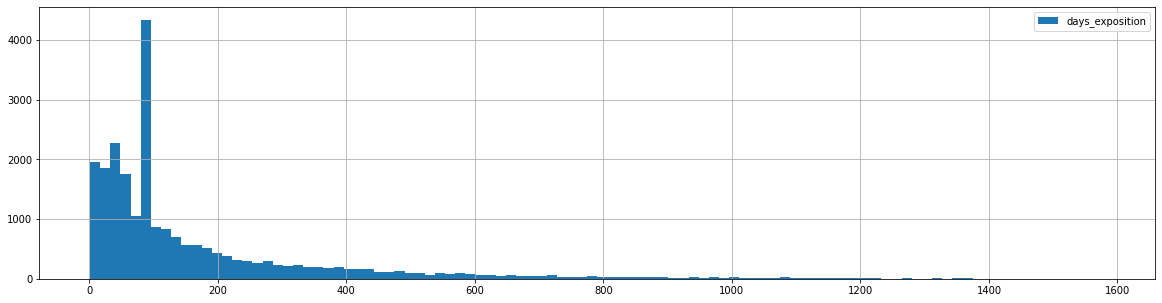

In [42]:
# проведем анализ скорости продажи квартир. Гистограмма близка к распределению Пуассона
df['days_exposition'].hist(legend='days_exposition', figsize=(20, 5), bins=100)
plt.show()

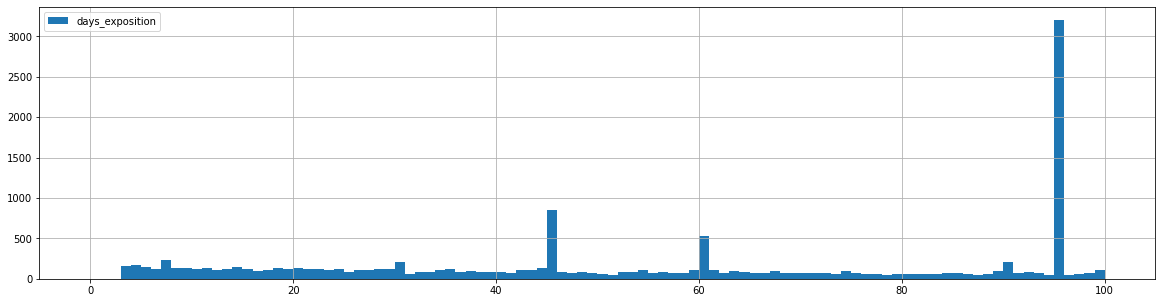

In [43]:
# в начале гистограммы виден выброс, рассмотрим этот участок подробнее
df['days_exposition'].hist(legend='days_exposition', figsize=(20, 5), bins=100, range=(0, 100))
plt.show()

Изучим столбец с днями показа обёявлений:

In [44]:
# найдем среднее и медиану
print(df['days_exposition'].mean())
print()
print(df['days_exposition'].median())

170.096097894917

95.0


Продажа квартиры всреднем занимает около полугода. Быстрой можно считать продажу в первую неделю, необычно долгой - занявшую более двух лет.

Проанализируем, какие факторы больше всего влияют на стоимость объекта:

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

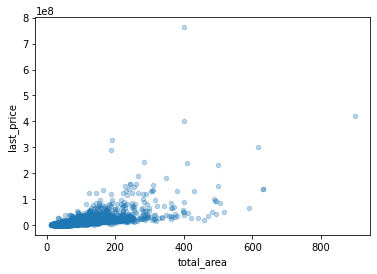

In [45]:
# зависит ли стоимость квартиры от общей площади?
df.plot(x='total_area', y='last_price', kind='scatter', alpha=0.3)

In [46]:
print(df['total_area'].corr(df['last_price']).round(2))

0.65


Наблюдается положительная кореляция

<font color='blue'> Посчитал кореляцию, где это возможно, некоторые выводы изменились </font>

<AxesSubplot:xlabel='good_living_area', ylabel='last_price'>

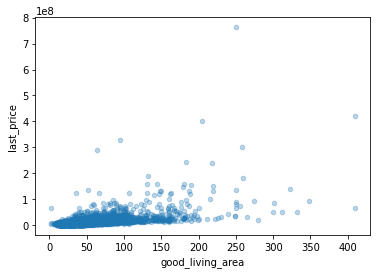

In [47]:
# зависит ли стоимость квартиры от жилой площади?
df['good_living_area'] = pd.to_numeric(df['living_area'].dropna(), errors='raise')
df.plot(x='good_living_area', y='last_price', kind='scatter', alpha=0.3)


In [48]:
print(df['good_living_area'].corr(df['last_price']).round(2))

0.57


Наблюдается положительная кореляция

<AxesSubplot:xlabel='good_kitchen_area', ylabel='last_price'>

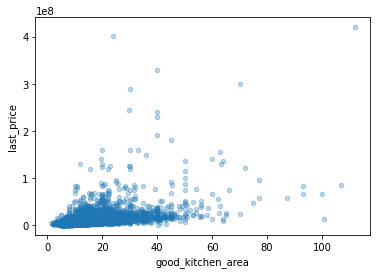

In [49]:
# зависит ли стоимость квартиры от площади кухни?
df['good_kitchen_area'] = pd.to_numeric(df['kitchen_area'].dropna(), errors='raise')
df.plot(x='good_kitchen_area', y='last_price', kind='scatter', alpha=0.3)

In [50]:
print(df['good_kitchen_area'].corr(df['last_price']).round(2))

0.52


Наблюдается положительная кореляция

<AxesSubplot:xlabel='rooms', ylabel='last_price'>

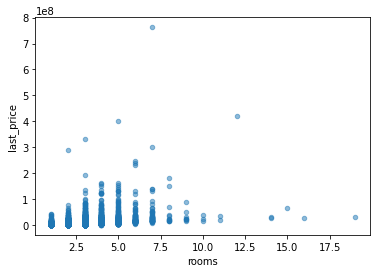

In [51]:
# зависит ли стоимость квартиры от количества комнат?
df.plot(x='rooms', y='last_price', kind='scatter', alpha=0.5)

In [52]:
print(df['rooms'].corr(df['last_price']).round(2))

0.37


Наблюдается незначительная положительная кореляция

<AxesSubplot:xlabel='floor_type', ylabel='last_price'>

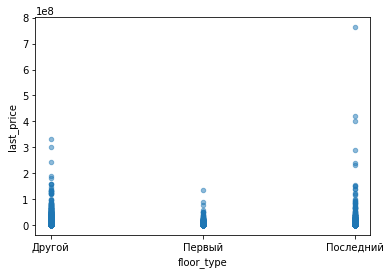

In [53]:
# зависит ли стоимость квартиры от типа этажа?
df.plot(x='floor_type', y='last_price', kind='scatter', alpha=0.5)

На первом и последнем этажах квартиры как правило дешевле, чем на других

<AxesSubplot:xlabel='publication_week_day', ylabel='last_price'>

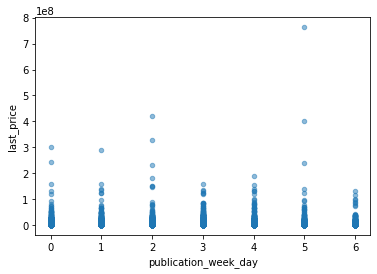

In [54]:
# зависит ли стоимость квартиры от дня недели публикации объявления?
df.plot(x='publication_week_day', y='last_price', kind='scatter', alpha=0.5)

Выраженной зависимости цены от дня недели публикации не наблюдается

<AxesSubplot:xlabel='publication_month', ylabel='last_price'>

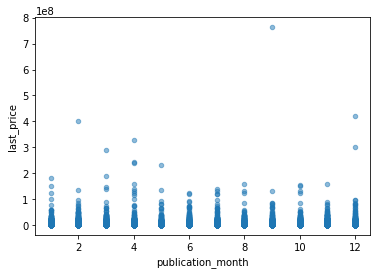

In [55]:
# зависит ли стоимость квартиры от месяца публикации объявления?
df.plot(x='publication_month', y='last_price', kind='scatter', alpha=0.5)

Выраженной зависимости цены от месяца публикации не наблюдается

<AxesSubplot:xlabel='publication_year', ylabel='last_price'>

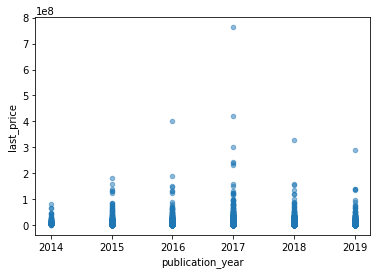

In [57]:
# зависит ли стоимость квартиры от года публикации объявления?
df.plot(x='publication_year', y='last_price', kind='scatter', alpha=0.5)

Выраженной зависимости цены от года публикации не наблюдается

In [58]:
# найдем среднюю цену квадратного метра в 10-ти населенных пунктах с наибольшим числом объявлений
# в начале найдем первые 10 населенных пунктов по количеству объявлений
top_ten = df.groupby('locality_name').size().sort_values(ascending=False).head(10)
#print(top_ten)
# затем сравним для них цену квадратного метра
print(
df.loc[df['locality_name'].isin([
    'Санкт-Петербург',
    'Всеволожск', 
    'Пушкин', 
    'поселок Шушары',
    'поселок Мурино', 
    'Колпино', 
    'Гатчина', 
    'Петергоф', 
    'поселок Парголово', 
    'Сестрорецк'])]
    .pivot_table(index='locality_name', values='square_meter_price', aggfunc='median').round(0)
    .sort_values(by='square_meter_price', ascending=False)
)

                   square_meter_price
locality_name                        
Санкт-Петербург              105132.0
Пушкин                       100000.0
Сестрорецк                    99917.0
поселок Парголово             92282.0
поселок Мурино                84969.0
Петергоф                      82812.0
поселок Шушары                77112.0
Колпино                       74861.0
Гатчина                       67925.0
Всеволожск                    65789.0


Самая высокая цена квадратного метра в Санкт-Петербурге - 105132, самая низкая в Всеволжске - 65789.

<AxesSubplot:xlabel='cityCenters_km', ylabel='last_price'>

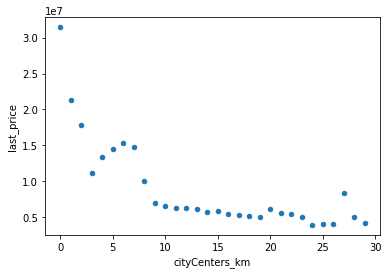

In [59]:
# найдём среднюю цену каждого километра от центра для Санкт-Петербурга
spb_price = df.loc[df['locality_name'] == 'Санкт-Петербург'].pivot_table(
    index='cityCenters_km',
    values='last_price', 
    aggfunc='mean').reset_index()
#print(spb_price)
spb_price.plot(x='cityCenters_km', y='last_price', kind='scatter', alpha=1.0, style='o-')

Судя по графику, цена квартиры уменьшается по мере отдаления от центра. Но уменьшается она неравномерно: в районе 5-го и 27-го километров наблюдаются выбросы.

### Общий вывод

Исследование данных показало, что цена обекта имеет положительную кореляцию с общей площадью, с жилой площадью и площадью кухни. Также незначительная положительная кореляция цены наблюдается с количеством комнат. Как правило, первые и последние этажи дешевле остальных. Для Санкт-Петербурга цена и расстояние имеют отрицательную кореляцию с выбросами в районе 5-го и 27-го километров. Зависимости от даты публикации не выявлено.

Для десяти населенных пунктов с наибольшим количеством объявлений самый дорогой квадратный метр в Санкт-Петербурге, самый дешевый во Всеволожске. 

Всреднем квартира продаётся за полгода. Быстрой можно считать продажу в первую неделю, необычно долгой - занявшую более двух лет. Наблюдается аномально большое число публикаций, продлившихся около 3-х месяцев.